In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

from lstm_vae import LSTM_VAE
from data_utils import generate_synthetic_data, create_sliding_windows, TimeSeriesDataset

Generating inference data with anomalies...
Loading model...
Running inference...
Plotting results...


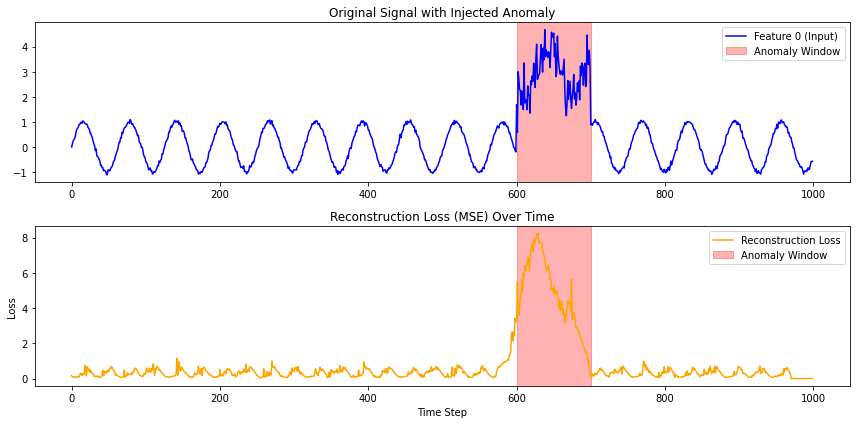

Done.


In [ ]:
def detect_anomalies():
    # --- Settings ---
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') # Inference is light, CPU is fine

    # --- Load Data & Inject Anomaly ---
    print("Generating inference data with anomalies...")
    total_length = 1000
    # Generate base data
    data = generate_synthetic_data(length=total_length, num_features=NUM_FEATURES, noise_level=0.05)
    
    # Define Anomaly Range (e.g., indices 600 to 700, representing "30-40 mins")
    anomaly_start = 600
    anomaly_end = 700
    
    # Inject Anomaly: Add a significant constant shift + extra noise to Feature 0
    data[anomaly_start:anomaly_end, 0] += 3.0 
    data[anomaly_start:anomaly_end, :] += np.random.normal(0, 0.5, (anomaly_end - anomaly_start, NUM_FEATURES))

    # Prepare for model
    windows = create_sliding_windows(data, SEQ_LEN)
    # Note: windows length will be total_length - SEQ_LEN
    
    # Convert to Tensora
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    # --- Load Model ---
    print("Loading model...")
    model = LSTM_VAE(input_dim=NUM_FEATURES, 
                     hidden_dim=HIDDEN_DIM, 
                     latent_dim=LATENT_DIM, 
                     seq_len=SEQ_LEN, 
                     device=DEVICE).to(DEVICE)
    
    model.load_state_dict(torch.load('lstm_vae_model.pth', map_location=DEVICE))
    model.eval()

    # --- Inference ---
    print("Running inference...")
    losses = []
    
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        
        # Calculate loss per window
        # recon shape: [num_windows, seq_len, num_features]
        # input shape: [num_windows, seq_len, num_features]
        
        # We calculate the Mean Absolute Error for Feature 0 specifically, 
        # averaged over the sequence length for each window.
        loss_matrix = criterion(recon, input_tensor) # [batch, seq, features]
        
        # Let's focus on the loss for Feature 0 (since we corrupted it most)
        # Summing loss over the sequence window
        feature_0_loss = loss_matrix[:, :, 0].mean(dim=1).numpy()
        
        losses = feature_0_loss

    # --- Visualization ---
    print("Plotting results...")
    # losses.to_excel('Losses.xlsxs')
    # Align loss with time (loss[i] corresponds to window starting at i)
    # We pad the beginning with zeros to match original time axis
    padded_losses = np.pad(losses, (0, SEQ_LEN), mode='constant', constant_values=0)
    

    plt.figure(figsize=(12, 6))
    
    # Plot Original Data (Feature 0)
    plt.subplot(2, 1, 1)
    plt.plot(data[:, 0], label='Feature 0 (Input)', color='blue')
    plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Window')
    plt.title('Original Signal with Injected Anomaly')
    plt.legend()
    
    # Plot Reconstruction Loss
    plt.subplot(2, 1, 2)
    plt.plot(padded_losses, label='Reconstruction Loss', color='orange')
    plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='Anomaly Window')
    plt.title('Reconstruction Loss (MSE) Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("Done.")

if __name__ == "__main__":
    detect_anomalies()

Generating inference data with anomalies...
Loading model...
Running inference...
Mean (Normal): 0.1067
Std (Normal): 0.1752
Threshold: 0.4571


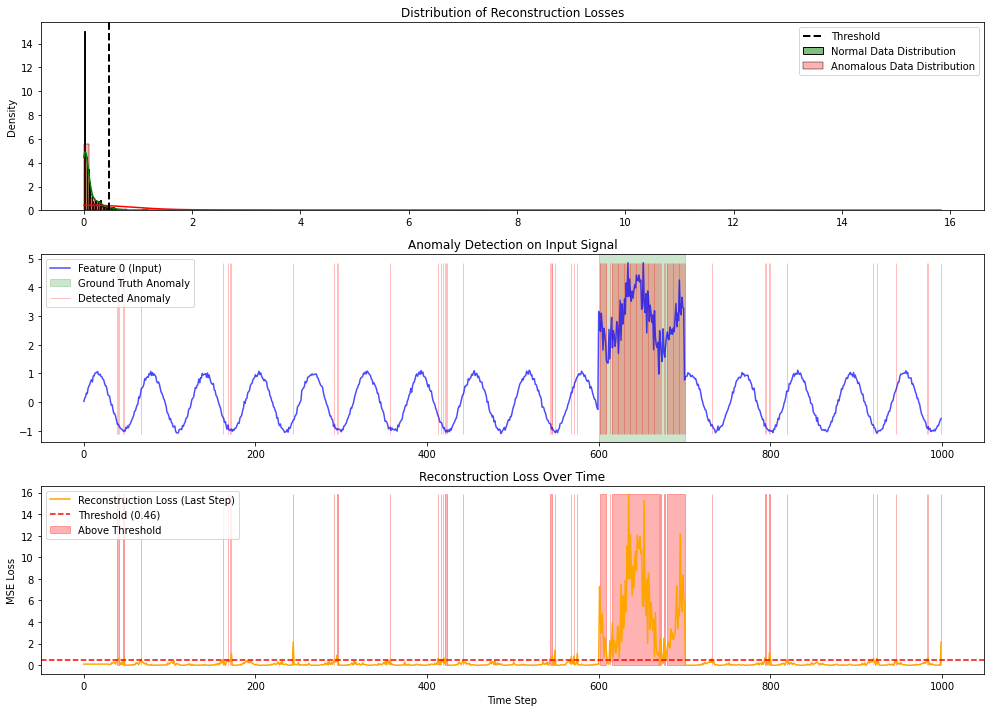

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

def detect_anomalies():
    # --- Settings ---
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') 

    # --- Load Data & Inject Anomaly ---
    print("Generating inference data with anomalies...")
    total_length = 1000
    data = generate_synthetic_data(length=total_length, num_features=NUM_FEATURES, noise_level=0.05)
    
    # Define Anomaly Range
    anomaly_start = 600
    anomaly_end = 700
    
    # Inject Anomaly
    data[anomaly_start:anomaly_end, 0] += 3.0 
    data[anomaly_start:anomaly_end, :] += np.random.normal(0, 0.5, (anomaly_end - anomaly_start, NUM_FEATURES))

    # Prepare for model
    windows = create_sliding_windows(data, SEQ_LEN)
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    # --- Load Model ---
    print("Loading model...")
    model = LSTM_VAE(input_dim=NUM_FEATURES, 
                     hidden_dim=HIDDEN_DIM, 
                     latent_dim=LATENT_DIM, 
                     seq_len=SEQ_LEN, 
                     device=DEVICE).to(DEVICE)
    try:
        model.load_state_dict(torch.load('lstm_vae_model.pth', map_location=DEVICE))
    except FileNotFoundError:
        print("Model file not found.")
        return
    model.eval()

    # --- Inference ---
    print("Running inference...")
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        loss_matrix = criterion(recon, input_tensor) 
        
        # --- FIX FOR LAG: USE LAST TIME STEP ONLY ---
        # Instead of averaging the whole window (which dilutes the error at the start),
        # we look at the error of the most recent point in the window.
        # This makes detection instantaneous.
        # Shape: [Batch, Seq_Len, Features] -> Take last seq point -> [Batch, Features]
        feature_0_loss = loss_matrix[:, -1, 0].numpy()
        
        losses = feature_0_loss

    # ---------------------------------------------------------
    # --- FIXED: STATISTICAL THRESHOLDING ON CLEAN DATA ---
    # ---------------------------------------------------------
    
    # We assume the first part of the inference data (e.g., 0 to 500) is "Normal"
    # In production, you would calculate this on your Validation Set.
    calibration_cutoff = 500 
    
    mu = np.mean(losses[:calibration_cutoff])
    sigma = np.std(losses[:calibration_cutoff])
    
    # Set Threshold
    threshold = mu + (2 * sigma) # Using 3 Sigma for robust outlier detection

    print(f"Mean (Normal): {mu:.4f}")
    print(f"Std (Normal): {sigma:.4f}")
    print(f"Threshold: {threshold:.4f}")

    # --- PADDING ---
    # Pad at the BEGINNING so index i in padded_losses corresponds to data[i]
    padded_losses = np.pad(losses, (SEQ_LEN, 0), mode='constant', constant_values=mu)

    # --- IDENTIFY ANOMALIES ---
    anomalies_idx = np.where(padded_losses > threshold)[0]
    
    # Filter out padding indices
    anomalies_idx = anomalies_idx[anomalies_idx >= SEQ_LEN]

    # ---------------------------------------------------------
    # --- PLOTTING ---
    # ---------------------------------------------------------
    plt.figure(figsize=(14, 10))
    
    # 1. Distribution Plot
    plt.subplot(3, 1, 1)
    sns.histplot(losses[:calibration_cutoff], kde=True, color='green', label='Normal Data Distribution', stat='density')
    sns.histplot(losses[calibration_cutoff:], kde=True, color='red', label='Anomalous Data Distribution', stat='density', alpha=0.3)
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')
    plt.title("Distribution of Reconstruction Losses")
    plt.legend()

    # 2. Original Signal with Detection
    plt.subplot(3, 1, 2)
    plt.plot(data[:, 0], label='Feature 0 (Input)', color='blue', alpha=0.7)
    
    # Ground Truth (Green zone)
    plt.axvspan(anomaly_start, anomaly_end, color='green', alpha=0.2, label='Ground Truth Anomaly')
    
    # Detected (Red Lines)
    if len(anomalies_idx) > 0:
        # Plotting vertical lines at every detected timestamp
        plt.vlines(anomalies_idx, ymin=min(data[:,0]), ymax=max(data[:,0]), 
                   colors='red', alpha=0.5, linewidth=0.5, label='Detected Anomaly')

    plt.title('Anomaly Detection on Input Signal')
    plt.legend(loc='upper left')
    
    # 3. Reconstruction Loss vs Threshold
    plt.subplot(3, 1, 3)
    plt.plot(padded_losses, label='Reconstruction Loss (Last Step)', color='orange')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
    
    # Fill detected region
    plt.fill_between(range(len(padded_losses)), 0, max(padded_losses), 
                     where=(padded_losses > threshold), 
                     color='red', alpha=0.3, label='Above Threshold')

    plt.title('Reconstruction Loss Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('MSE Loss')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_anomalies()

Generating data with PRECURSOR (Early Warning)...
Threshold: 0.5838


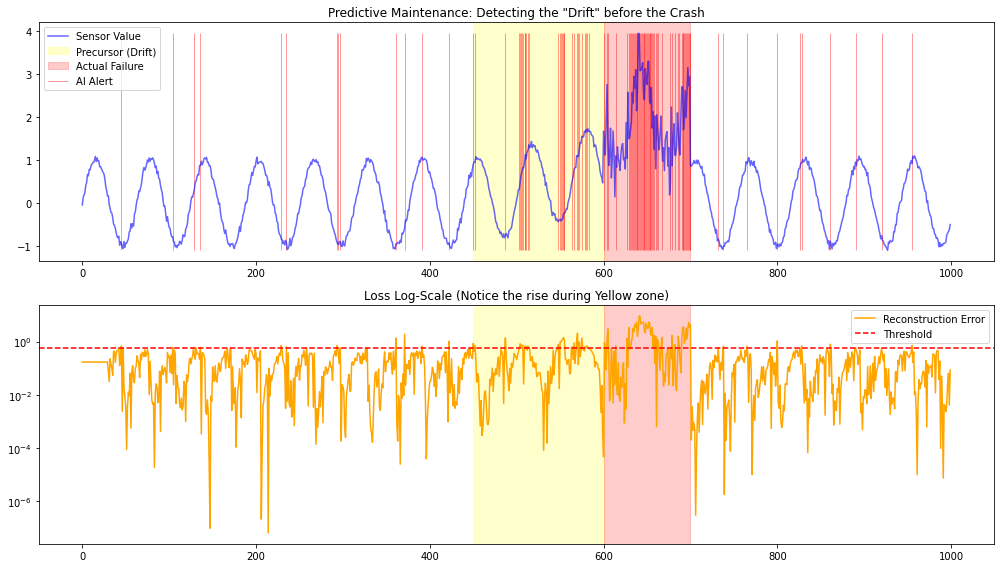

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# --- 1. Modified Data Generation with Precursor ---
def generate_synthetic_data_with_precursor(length=1000, num_features=3, noise_level=0.05):
    t = np.linspace(0, 100, length)
    data = np.zeros((length, num_features))
    
    # Feature 0: Sine wave (The one we will break)
    data[:, 0] = np.sin(t)
    
    # Other features
    data[:, 1] = np.cos(t)
    for i in range(2, num_features):
        freq = 1 + (i * 0.5)
        data[:, i] = np.sin(t * freq)
    
    # Add base noise
    data = data + np.random.normal(0, noise_level, data.shape)
    
    return data.astype(np.float32)

def create_sliding_windows(data, seq_length):
    x = []
    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        x.append(_x)
    return np.array(x)

# --- 2. LSTM VAE Class (Same as before) ---
class LSTM_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len, device='cpu'):
        super(LSTM_VAE, self).__init__()
        self.seq_len = seq_len
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_z_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n.squeeze(0)
        return self.fc_mu(h_n), self.fc_logvar(h_n)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        hidden_map = self.fc_z_to_hidden(z)
        decoder_input = hidden_map.unsqueeze(1).repeat(1, self.seq_len, 1)
        out, _ = self.decoder_lstm(decoder_input)
        return self.fc_output(out)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 3. Main Execution ---
def detect_early_warnings():
    # Settings
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') 

    # --- Generate Data ---
    print("Generating data with PRECURSOR (Early Warning)...")
    total_length = 1000
    data = generate_synthetic_data_with_precursor(length=total_length, num_features=NUM_FEATURES)
    
    # --- INJECT FAULTS ---
    # 1. The Precursor (Drift/Overheating): Index 450 to 600
    # The machine is struggling, but hasn't broken yet.
    # We add a gradual linear drift.
    drift_start = 450
    drift_end = 600
    drift_strength = np.linspace(0, 0.8, drift_end - drift_start) # Gradual increase
    data[drift_start:drift_end, 0] += drift_strength

    # 2. The Failure (Breakdown): Index 600 to 700
    # Massive noise and offset
    failure_start = 600
    failure_end = 700
    data[failure_start:failure_end, 0] += 2.0 # Huge offset
    data[failure_start:failure_end, :] += np.random.normal(0, 0.5, (failure_end - failure_start, NUM_FEATURES))

    # Create Windows
    windows = create_sliding_windows(data, SEQ_LEN)
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    # --- Load Model ---
    model = LSTM_VAE(input_dim=NUM_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN, device=DEVICE).to(DEVICE)
    try:
        model.load_state_dict(torch.load('lstm_vae_model.pth', map_location=DEVICE))
    except:
        print("Please train the model first!")
        return
    model.eval()

    # --- Inference ---
    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        loss_matrix = criterion(recon, input_tensor) 
        # Use Last Step Error for instant detection
        losses = loss_matrix[:, -1, 0].numpy()

    # --- Calibration (Normal Data only) ---
    calibration_cutoff = 400 # Before even the drift starts
    mu = np.mean(losses[:calibration_cutoff])
    sigma = np.std(losses[:calibration_cutoff])
    
    # TIGHTER THRESHOLD to catch the drift
    threshold = mu + (2.0 * sigma) 

    print(f"Threshold: {threshold:.4f}")

    padded_losses = np.pad(losses, (SEQ_LEN, 0), mode='constant', constant_values=mu)
    anomalies_idx = np.where(padded_losses > threshold)[0]
    anomalies_idx = anomalies_idx[anomalies_idx >= SEQ_LEN]

    # --- Plotting ---
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(data[:, 0], label='Sensor Value', color='blue', alpha=0.6)
    
    # Zone 1: Early Warning (Yellow)
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.2, label='Precursor (Drift)')
    # Zone 2: Failure (Red)
    plt.axvspan(failure_start, failure_end, color='red', alpha=0.2, label='Actual Failure')
    
    # Detection Lines
    if len(anomalies_idx) > 0:
        plt.vlines(anomalies_idx, ymin=min(data[:,0]), ymax=max(data[:,0]), 
                   colors='red', alpha=0.8, linewidth=0.5, label='AI Alert')
        
    plt.title('Predictive Maintenance: Detecting the "Drift" before the Crash')
    plt.legend(loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(padded_losses, label='Reconstruction Error', color='orange')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.2)
    plt.axvspan(failure_start, failure_end, color='red', alpha=0.2)
    plt.yscale('log') # Log scale helps see small drifts better
    plt.title('Loss Log-Scale (Notice the rise during Yellow zone)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_early_warnings()

Generating data...
Mean: 0.1419, Sigma: 0.0804
Tight Threshold: 0.3831


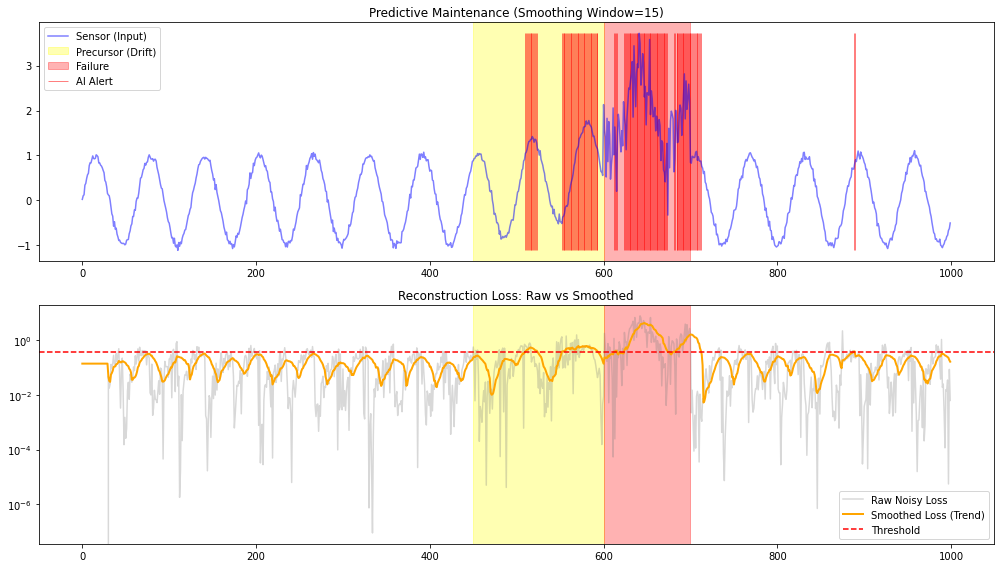

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd # We use pandas for the rolling average
import matplotlib.pyplot as plt

# --- 1. Data Generation (Same as before) ---
def generate_synthetic_data_with_precursor(length=1000, num_features=3):
    t = np.linspace(0, 100, length)
    data = np.zeros((length, num_features))
    data[:, 0] = np.sin(t) # Feature 0
    data[:, 1] = np.cos(t)
    for i in range(2, num_features):
        data[:, i] = np.sin(t * (1 + i*0.5))
    
    # Add noise
    data = data + np.random.normal(0, 0.05, data.shape)
    return data.astype(np.float32)

def create_sliding_windows(data, seq_length):
    x = []
    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        x.append(_x)
    return np.array(x)

# --- 2. Model (Same as before) ---
class LSTM_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len, device='cpu'):
        super(LSTM_VAE, self).__init__()
        self.seq_len = seq_len
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_z_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n.squeeze(0)
        return self.fc_mu(h_n), self.fc_logvar(h_n)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        hidden_map = self.fc_z_to_hidden(z)
        decoder_input = hidden_map.unsqueeze(1).repeat(1, self.seq_len, 1)
        out, _ = self.decoder_lstm(decoder_input)
        return self.fc_output(out)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 3. Inference with Smoothing ---
def detect_early_warnings():
    SEQ_LEN = 30
    NUM_FEATURES = 3
    HIDDEN_DIM = 64
    LATENT_DIM = 16
    DEVICE = torch.device('cpu') 

    # --- Generate Data & Inject Drift ---
    print("Generating data...")
    data = generate_synthetic_data_with_precursor(length=1000, num_features=NUM_FEATURES)
    # PRECURSOR (Drift): 450 -> 600
    drift_start, drift_end = 450, 600
    # Create a linear drift from 0 to 0.8
    drift_values = np.linspace(0, 0.8, drift_end - drift_start)
    data[drift_start:drift_end, 0] += drift_values
    # FAILURE (Crash): 600 -> 700
    fail_start, fail_end = 600, 700
    data[fail_start:fail_end, 0] += 2.0
    data[fail_start:fail_end, :] += np.random.normal(0, 0.5, (fail_end - fail_start, NUM_FEATURES))

    # Prepare Data
    windows = create_sliding_windows(data, SEQ_LEN)
    input_tensor = torch.tensor(windows).float().to(DEVICE)

    # Load Model
    model = LSTM_VAE(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, SEQ_LEN, DEVICE).to(DEVICE)
    try:
        model.load_state_dict(torch.load('lstm_vae_model.pth', map_location=DEVICE))
    except:
        print("Model not found. Run train.py first.")
        return
    model.eval()

    # Calculate Raw Losses
    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        recon, _, _ = model(input_tensor)
        loss_matrix = criterion(recon, input_tensor)
        # Raw loss of the last step
        raw_losses = loss_matrix[:, -1, 0].numpy()

    # We apply a Rolling Mean (Moving Average) of 10 steps.
    # This kills the noise but keeps the drift trend.
    smoothing_window = 15
    smoothed_losses = pd.Series(raw_losses).rolling(window=smoothing_window, min_periods=1).mean().values

    # --- Calibration (on Smoothed Data) ---
    # We calibrate on the first 400 points (Normal operation)
    calib_data = smoothed_losses[:400]
    mu = np.mean(calib_data)
    sigma = np.std(calib_data)
    
    # Because we smoothed the data, Sigma is now very small.
    # This allows us to set a very tight threshold.
    threshold = mu + (3 * sigma)

    print(f"Mean: {mu:.4f}, Sigma: {sigma:.4f}")
    print(f"Tight Threshold: {threshold:.4f}")

    # Pad to match time axis
    padded_losses = np.pad(smoothed_losses, (SEQ_LEN, 0), mode='constant', constant_values=mu)
    
    # Detect
    anomalies_idx = np.where(padded_losses > threshold)[0]
    anomalies_idx = anomalies_idx[anomalies_idx >= SEQ_LEN]

    # --- Plotting ---
    plt.figure(figsize=(14, 8))

    # Top Plot: Sensor Data
    plt.subplot(2, 1, 1)
    plt.plot(data[:, 0], label='Sensor (Input)', color='blue', alpha=0.5)
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3, label='Precursor (Drift)')
    plt.axvspan(fail_start, fail_end, color='red', alpha=0.3, label='Failure')
    
    # Plot Alert Lines
    if len(anomalies_idx) > 0:
        plt.vlines(anomalies_idx, ymin=min(data[:,0]), ymax=max(data[:,0]), 
                   colors='red', alpha=1.0, linewidth=0.5, label='AI Alert')
        
    plt.title(f'Predictive Maintenance (Smoothing Window={smoothing_window})')
    plt.legend(loc='upper left')

    # Bottom Plot: Smoothed Loss
    plt.subplot(2, 1, 2)
    # Plot faint raw loss for comparison
    plt.plot(np.pad(raw_losses, (SEQ_LEN,0)), color='gray', alpha=0.3, label='Raw Noisy Loss')
    # Plot smooth loss
    plt.plot(padded_losses, color='orange', linewidth=2, label='Smoothed Loss (Trend)')
    
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
    plt.axvspan(drift_start, drift_end, color='yellow', alpha=0.3)
    plt.axvspan(fail_start, fail_end, color='red', alpha=0.3)
    
    plt.yscale('log')
    plt.title('Reconstruction Loss: Raw vs Smoothed')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    detect_early_warnings()